In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import sep
from os.path import join, isfile, dirname, basename, relpath, normpath
from orjson import loads, dumps
import itertools

/home/han/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/han/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


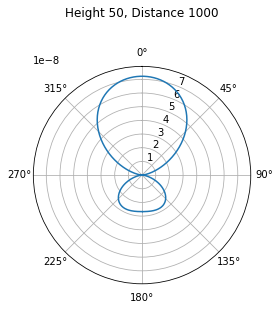

In [16]:
def adcock_two_element_mark1(theta, R, H, Ptag, pLossFactor,fc, Lcable, Dant, Patmo):
    """
    The array is located in the XY-plane with the elements pointing
    along Y and the boom forward direction along X

    H is the height of the tag below the XY-plane
    R is the range from the array centre to the tag in the XY plane
    Dp/Dn are the distances to the tag from the elements.
    Dant is the distance between the antenna elements
    phic is the cable phase difference (radians)

    Model the pattern by  rotating the tag (and not the array) at fixed
    radius in XY plane (fixed altitude H).

    For a horizontally polarised array, a tag produces maximum signal
    when it is oriented parallel to an array element and perpendicular
    to the Dp/Dm vectors. 

    At each point in the scan, reorient the tag for maximum signal.
    We assume that the tag maintains this orientation as it rotates in
    the XY plane around the array.

    Assume Dant << np.sqrt(H**2 + R**2) so that each element sees the same
    E-field magnitude and orientation (but not phase) from the tag. 
    """
    
    cc = 2e8; #cable speed of light
    cv = 3e8; #vacuum speed of light
    Lc = cc / fc;  
    Lv = cv / fc; 
    kv = 2 * np.pi / Lv;

    phic =  2 * np.pi * Lcable / Lc;
    Rp = np.sqrt( (R * np.cos(theta) - Dant / 2)**2 + (R * np.sin(theta))**2 );
    Rm = np.sqrt( (R * np.cos(theta) + Dant / 2)**2 + (R * np.sin(theta))**2 );

    Dp = np.sqrt( H**2 + Rp**2 );
    Dm = np.sqrt( H**2 + Rm**2 );

    pLossp = (Lv/4/np.pi/Dp)**pLossFactor;
    pLossm = (Lv/4/np.pi/Dm)**pLossFactor;
    
    PbeamS = (np.exp(1j * kv * Dp) * np.sqrt(pLossp) * np.exp(1j * phic) + np.exp(1j * kv * Dm) * np.sqrt(pLossm)) ** 2
    PbeamS = PbeamS * np.square(np.cos(theta)) * Ptag
    
    return PbeamS

def adcock_two_element(phis, H, R):
    """
    adcock_butler Calculates theoretical antenna gain-pattern based on bearing-to-tag
    """

    Ptag = 1; #use uW (microW).

    #H = 50;
    #R = 1000;
    pLossFactor = 2;
    fc = 151e6;
    Dant    = .50;
    Lcable  = 0.1;

    FAMdB = 0;                                  #Noise figure of atmo. above thermal
    Tamb = 300;                                 #ambient temperature (Kelvin) 
    kB = 1.38e-23;                              #Boltzmann's constant J/oK
    Tpulse = 0.0135;                            #Tag pulse frequency (time window)
    BW = 2/Tpulse;                              #Tag occunp.pied bandwidth
    Patmo = 10**(FAMdB/10) * kB * Tamb * BW;     #Ambient noise power in tag bandwidth

    g = adcock_two_element_mark1(phis, R, H, Ptag, pLossFactor,fc, Lcable, Dant, Patmo)
    
    return g

aoa = np.arange(-np.pi,np.pi,np.pi*2/360)
db = adcock_two_element(aoa,50,1000)
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.plot(aoa, db)
ax.set_title('Height 50, Distance 1000', y=1.2)
ax.set_ylim([0, db.max()*1.1])
plt.show()
plt.close()

In [3]:
def find_valid_collection_paths(all_paths):
    analysis_paths = filter(lambda path: path.endswith("Analysis.json"), all_paths)
    valid_analysis_paths = filter(lambda path: join(dirname(path), "recording.json") in all_paths, analysis_paths)
    return map(lambda path: dirname(path), valid_analysis_paths)

def find_collection_paths(root):
    all_paths = map(lambda file: relpath(file, root), glob(join(root, '**/*.json'), recursive=True))  # find all file end with .json
    return find_valid_collection_paths(list(all_paths))

root = "/home/han/Codes/collection-internal"
paths = list(find_collection_paths(root))
paths[0]

'2021-02-10/PreRelease-System13/collection--2021-02-10_09_43_21_139'

In [4]:
f = open(join(root, paths[5], "Analysis.json"), 'r')
data = loads(f.read())
tag = data['tags'][0]
tag.keys()

dict_keys(['angles', 'band_khz', 'discarded_bearing', 'elevation_distance_data', 'estimated_bearing', 'estimated_location', 'known_location', 'known_location_x_y', 'label', 'latest_pulse_count', 'latest_pulses_per_minute', 'max_stability', 'profile_data', 'reference', 'scan_beam_match_pulses', 'scan_noise', 'scan_pulses', 'species', 'tag_freq'])

In [5]:
# known tag location 
known_location_x_y = tag['known_location_x_y']
known_location_x_y = np.array([known_location_x_y['x'], known_location_x_y['y']])
known_location_x_y

array([-275.43629147, -222.56765392])

In [6]:
# pulses 
scan_pulses = list(map(lambda x: [x['x_y']['x'], x['x_y']['y'], x['yaw'], x['signal_db']],itertools.chain.from_iterable(tag['scan_pulses'])))
scan_pulses = np.array(scan_pulses)
scan_pulses[:,2] = scan_pulses[:,2] / 180 * np.pi    # [0: 2*pi]
scan_pulses.shape   # x, y, theta, signal_db

(244, 4)

In [7]:
# search region (in meter)
x_min = np.floor(scan_pulses[:,0].min()) - 500
x_max = np.ceil(scan_pulses[:,0].max()) + 500
y_min = np.floor(scan_pulses[:,1].min()) - 500
y_max = np.ceil(scan_pulses[:,1].max()) + 500
x = np.arange(x_min, x_max, 10)
y = np.arange(y_min, y_max, 10)
xx, yy = np.meshgrid(x, y)

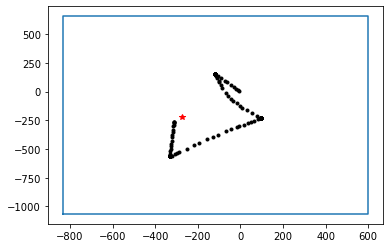

In [8]:
plt.figure
plt.plot(scan_pulses[:,0], scan_pulses[:,1], '.k')
plt.plot(known_location_x_y[0], known_location_x_y[1], '*r')
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min])
# plt.plot(xx, yy, 'g.')
plt.show()
plt.close()